# Machine Learning Lab 08 - Solutions

Hyper-parameter optimisation, feature selection and PCA.

## Imports

In [1]:
# Data and Datasets
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Hyper-parameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature selection & feature engineering
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

# Stats
from scipy.stats import randint as sp_randint
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro     # Shapiro Wilk
from scipy.stats import normaltest  # D’Agostino’s K^2
from scipy.stats import anderson    # Anderson-Darling
from scipy.stats import ttest_ind    # independent student t-test; assumes normality
from scipy.stats import mannwhitneyu # non-parametric; doesn't assume normality

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz

# Utils
import pprint
import numpy as np
from time import time

## Loading wine dataset

In [2]:
# Loading the dataset
dataset = load_wine()

# Convert to Pandas DataFrame
dataset_df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                     columns=dataset['feature_names'] + ['target'])

# Converting class labels to int
dataset_df['target'] = dataset_df['target'].astype('int')

# Storing references to feature names and (unique) class labels
feature_names = dataset['feature_names']
class_labels = dataset_df['target'].unique().astype('str')

# Get the X (feature matrix) and y (class label vector) from the data
X, y = dataset.data, dataset.target

print("Shape of feature matrix:", X.shape)

# And just to ensure we've loaded what we expect..
dataset_df.head()

Shape of feature matrix: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Utility functions

In [3]:
# Visualising the Decision Tree
def visualise_tree(model, feature_names, class_labels):
    """
    A function to visualise a decision tree model. This requires graphviz to be installed.
    :param model: the decision tree model
    :param feature_list: a list of names for the features
    :param class_labels: a list of names for the class labels
    """
    graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=feature_names, class_names=class_labels
       , filled = True))
    graph_svg = SVG(graph.pipe(format='svg'))
    display(graph_svg)

In [4]:
# Utility function to report best scores
def report(results, rank_metric='score', n_top=3):
    """
    Utility function to report best scores.
    :param results: the cv_results_ data structure from the optimisation algorithm
    :param rank_metric: name of the metric to report results for
    :param n_top: the number of top results to report
    """
    print("\nModels ranked according to", rank_metric)
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_" + rank_metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.2f} (+/- {1:.2f})".format(
                  results["mean_test_" + rank_metric][candidate],
                  results["std_test_" + rank_metric][candidate]*2))
            print("Params: {0}".format(results['params'][candidate]))
            print("")

## Manual hyper-parameter optimisation

Accuracy: 0.90 (+/- 0.21)


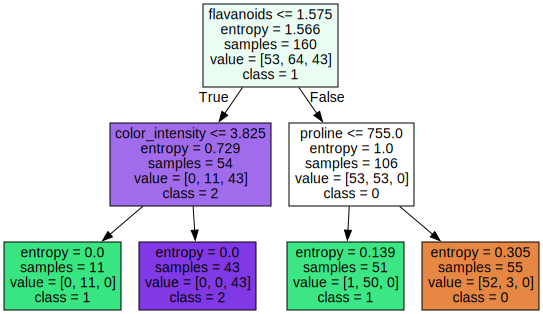

In [5]:
# Instanting model
model = DecisionTreeClassifier(random_state=None, 
                               max_depth=2, # smaller or larger depth?
                               criterion='entropy') # gini vs entropy?

# 10-fold cross-validation
scores = cross_validate(model, X, y, cv=10, return_estimator=True)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

# Getting the trained model from the 1st fold
model = scores['estimator'][0]

# Visualising the tree
visualise_tree(model, feature_names, class_labels)

## Hyper-parameter optimisation

Examples modified from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
 * [Randomised Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
 * [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Random Search

In [6]:
# instantiating the model
model = DecisionTreeClassifier()

# specify parameters and distributions to sample from
param_dict = {"max_depth": [2, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# run random search
print("> STARTING RANDOM SEARCH ...")
n_iter_search = 200
n_folds = 10

random_search = RandomizedSearchCV(model, param_distributions=param_dict,
                                   n_iter=n_iter_search, cv=n_folds)

start_time = time()
random_search.fit(X, y)
end_time = time()


print("> RANDOM SEARCH COMPLETE")

print("\nRandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end_time - start_time), n_iter_search))
report(random_search.cv_results_)

> STARTING RANDOM SEARCH ...
> RANDOM SEARCH COMPLETE

RandomizedSearchCV took 0.90 seconds for 200 candidates parameter settings.

Models ranked according to score
Model with rank: 1
Mean validation score: 0.95 (+/- 0.09)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_split': 5, 'splitter': 'best'}

Model with rank: 2
Mean validation score: 0.93 (+/- 0.16)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 2, 'splitter': 'best'}

Model with rank: 2
Mean validation score: 0.93 (+/- 0.11)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 2, 'splitter': 'best'}

Model with rank: 2
Mean validation score: 0.93 (+/- 0.10)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 3, 'splitter': 'best'}



### Grid Search

In [7]:
# instantiating the model
model = DecisionTreeClassifier()

# defining parameter grid
param_grid = {"max_depth": [2, 4, 6, 8, None],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 6, 8, 10],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# run grid search
print("\n> STARTING GRID SEARCH ...")
grid_search = GridSearchCV(model, param_grid=param_grid, cv=n_folds)

start_time = time()
grid_search.fit(X, y)
end_time = time()

print("> GRID SEARCH COMPLETE")

print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (end_time - start_time, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


> STARTING GRID SEARCH ...
> GRID SEARCH COMPLETE

GridSearchCV took 2.34 seconds for 500 candidate parameter settings.

Models ranked according to score
Model with rank: 1
Mean validation score: 0.96 (+/- 0.11)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 8, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 2
Mean validation score: 0.96 (+/- 0.08)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_split': 2, 'splitter': 'best'}

Model with rank: 3
Mean validation score: 0.95 (+/- 0.20)
Params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'min_samples_split': 10, 'splitter': 'best'}

Model with rank: 3
Mean validation score: 0.95 (+/- 0.12)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 2, 'splitter': 'best'}



### Multi-metric evaluation for GridSearch 

Defining metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Done something similar previously. See Lab 07 (solutions).

Another example you may find interesting: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

In [8]:
# instantiating the model
model = DecisionTreeClassifier()

# defining parameter grid
param_grid = {"max_depth": [2, 4, 6, 8, None],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 6, 8, 10],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# defining multiple metrics for scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'prec_macro': make_scorer(precision_score, average='macro', zero_division=0), 
    'rec_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# run grid search
print("\n> STARTING GRID SEARCH ...")
n_folds = 10
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           cv=n_folds, 
                           scoring=scoring, 
                           refit='prec_macro')
start = time()
grid_search.fit(X, y)

print("> GRID SEARCH COMPLETE")
print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Get the best model according to each of the 3 metrics used
report(grid_search.cv_results_, 'accuracy', n_top=1)
report(grid_search.cv_results_, 'prec_macro', n_top=1)
report(grid_search.cv_results_, 'rec_macro', n_top=1)

try:
    print("Best score: %0.2f " % (grid_search.best_score_))
except:
    print("Best score not available (refit set to False presumably)")


> STARTING GRID SEARCH ...
> GRID SEARCH COMPLETE

GridSearchCV took 6.81 seconds for 500 candidate parameter settings.

Models ranked according to accuracy
Model with rank: 1
Mean validation score: 0.96 (+/- 0.07)
Params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'min_samples_split': 2, 'splitter': 'best'}


Models ranked according to prec_macro
Model with rank: 1
Mean validation score: 0.96 (+/- 0.05)
Params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'min_samples_split': 2, 'splitter': 'best'}


Models ranked according to rec_macro
Model with rank: 1
Mean validation score: 0.96 (+/- 0.07)
Params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 6, 'min_samples_split': 2, 'splitter': 'best'}

Best score: 0.96 


### BONUS: Parallel GridSearch

Out of the box, Python, Jupyter notebook and Scikit-Learn will be limited to 1 CPU / process / core / thread. If you have a multi-core CPU, for example, you can speed things up by running things in parallel.

Great article about it here: https://machinelearningmastery.com/multi-core-machine-learning-in-python/

In short, we'll add an argument to our GridSearchCV, below: ``n_jobs``, which you can set to the number of jobs you want running in parallel. Obviously, don't set this number higher than what your hardware can actually support...

**PS**: you can do this to different models and functions, so not limited to these hyper-parameter optimisation functions. Have a look at the above article for some more uses of this.

In [9]:
# instantiating the model
model = DecisionTreeClassifier()

# defining parameter grid
param_grid = {"max_depth": [2, 4, 6, 8, None],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 6, 8, 10],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# defining multiple metrics for scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'prec_macro': make_scorer(precision_score, average='macro', zero_division=0), 
    'rec_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# run grid search
print("\n> STARTING GRID SEARCH ...")
n_folds = 10
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           cv=n_folds, 
                           scoring=scoring, 
                           refit='prec_macro',
                           n_jobs=4)
start = time()
grid_search.fit(X, y)

print("> GRID SEARCH COMPLETE")
print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Get the best model according to each of the 3 metrics used
report(grid_search.cv_results_, 'accuracy', n_top=1)
report(grid_search.cv_results_, 'prec_macro', n_top=1)
report(grid_search.cv_results_, 'rec_macro', n_top=1)

try:
    print("Best score: %0.2f " % (grid_search.best_score_))
except:
    print("Best score not available (refit set to False presumably)")


> STARTING GRID SEARCH ...
> GRID SEARCH COMPLETE

GridSearchCV took 3.15 seconds for 500 candidate parameter settings.

Models ranked according to accuracy
Model with rank: 1
Mean validation score: 0.96 (+/- 0.10)
Params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'min_samples_split': 4, 'splitter': 'random'}

Model with rank: 1
Mean validation score: 0.96 (+/- 0.11)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 2, 'splitter': 'best'}


Models ranked according to prec_macro
Model with rank: 1
Mean validation score: 0.97 (+/- 0.06)
Params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'min_samples_split': 4, 'splitter': 'random'}


Models ranked according to rec_macro
Model with rank: 1
Mean validation score: 0.96 (+/- 0.10)
Params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'min_samples_split': 4, 'splitter': 'random'}

Best score: 0.97 


## Recursive Feature Elimination

In [10]:
# Instantiating classifier (with default hyper-parameter values)
model = DecisionTreeClassifier()

# Instantiating (setting up) RFE
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

start_time = time()
rfecv.fit(X, y)
end_time = time()

# Printing out the results
print("RFECV took %.2f seconds to identify %d features" % 
      ((end_time - start_time), rfecv.n_features_))
print(rfecv.ranking_)

RFECV took 0.04 seconds to identify 4 features
[ 3  9 10  8  6  7  1  5  4  2  1  1  1]


In [11]:
# Creating a DataFrame to display the original columns and their ranking
feature_ranking_df = pd.DataFrame()
feature_ranking_df['feature'] = dataset['feature_names']
feature_ranking_df['rank'] = rfecv.ranking_

feature_ranking_df = feature_ranking_df.sort_values(by='rank', ascending=True)
feature_ranking_df

,feature,rank
6,flavanoids,1
10,hue,1
11,od280/od315_of_diluted_wines,1
12,proline,1
9,color_intensity,2
0,alcohol,3
8,proanthocyanins,4
7,nonflavanoid_phenols,5
4,magnesium,6
5,total_phenols,7


## Random Forest Feature Selection

In [12]:
# Instantiating RandomForest classifier (with default hyper-parameter values)
model = RandomForestClassifier(n_estimators=200,random_state=None)

# 5-fold cross validation, returning a trained model
scores = cross_validate(model, X, y, cv=5, return_estimator=True)

# Getting the trained model from the 1st fold
estimator = scores['estimator'][0]

In [13]:
# Creating a DataFrame to display the original columns and their importance
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = dataset['feature_names']
feature_importance_df['importance'] = estimator.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)
#feature_importance_df

<Axes: title={'center': 'RF Feature Importance'}, ylabel='feature'>

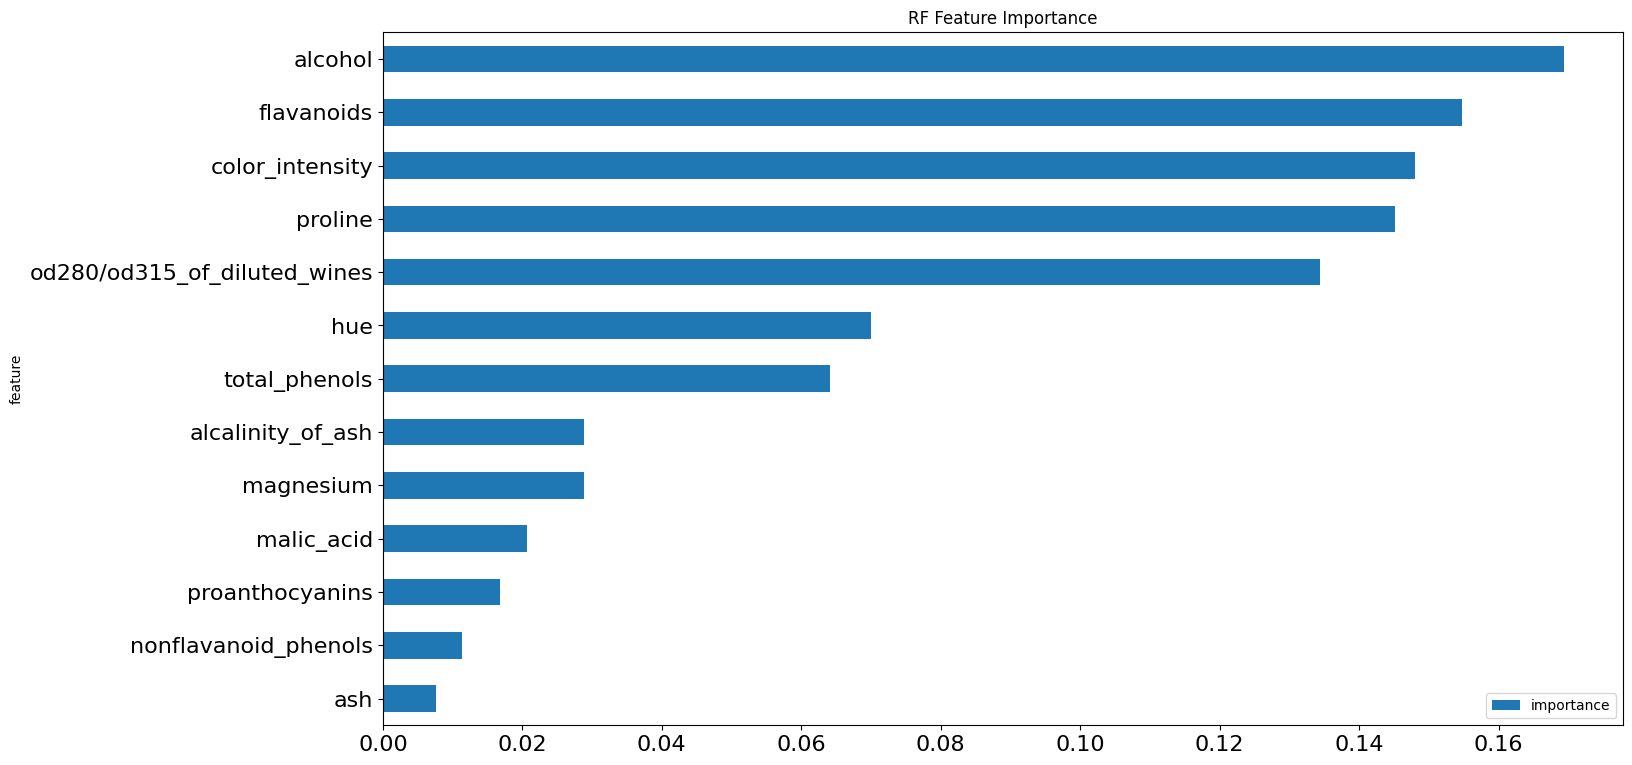

In [14]:
feature_importance_df.plot(kind='barh',
                           x='feature', 
                           y='importance',
                           title='RF Feature Importance',
                           xlabel='',
                           figsize=(16, 9),
                           fontsize=16)

## Principal Component Analysis

<Axes: >

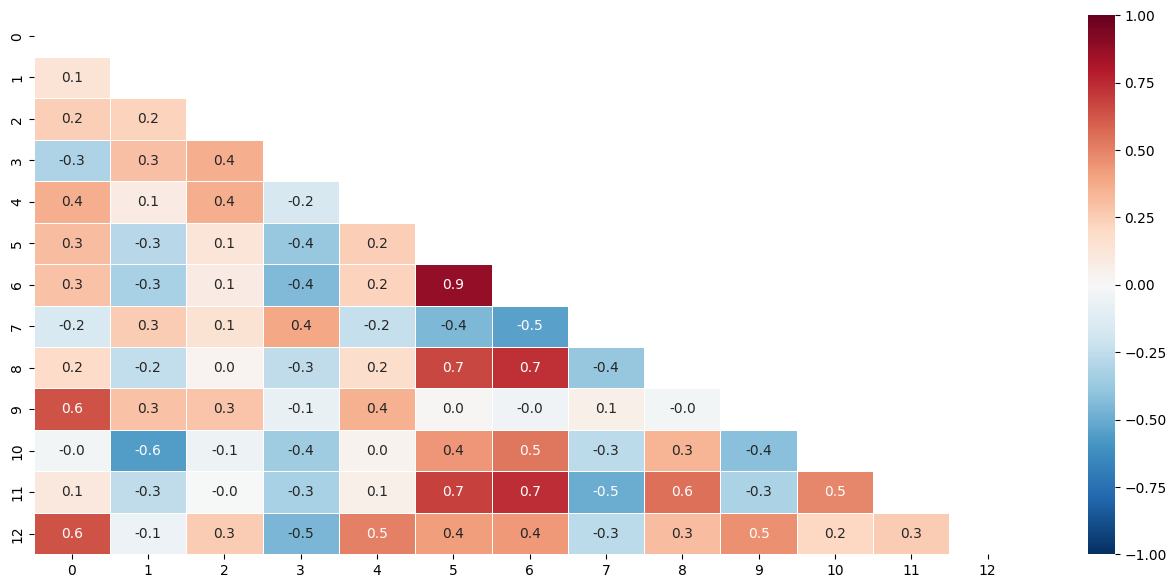

In [15]:
# Using Sparman's (non-linear relationship) - doesn't assume normal distribution
corr, _ = spearmanr(X)

# Getting just the triangle of the correlation matrix
triangle = np.triu(corr)

# Plotting a heatmap with Seaborn
plt.figure(figsize=(16, 7))
sns.heatmap(data=corr, annot=True, mask=triangle, vmin=-1, vmax=1, cmap='RdBu_r', linewidths=.5, fmt= '.1f') # with 1 decimal precision

In [18]:
# Applying PCA, set to generate 10 Principal Components here
pca = PCA(n_components=10)

X_pca = pca.fit_transform(X)

print("Old shape:",X.shape)
print("New shape:",X_pca.shape)

Old shape: (178, 13)
New shape: (178, 10)


<Axes: >

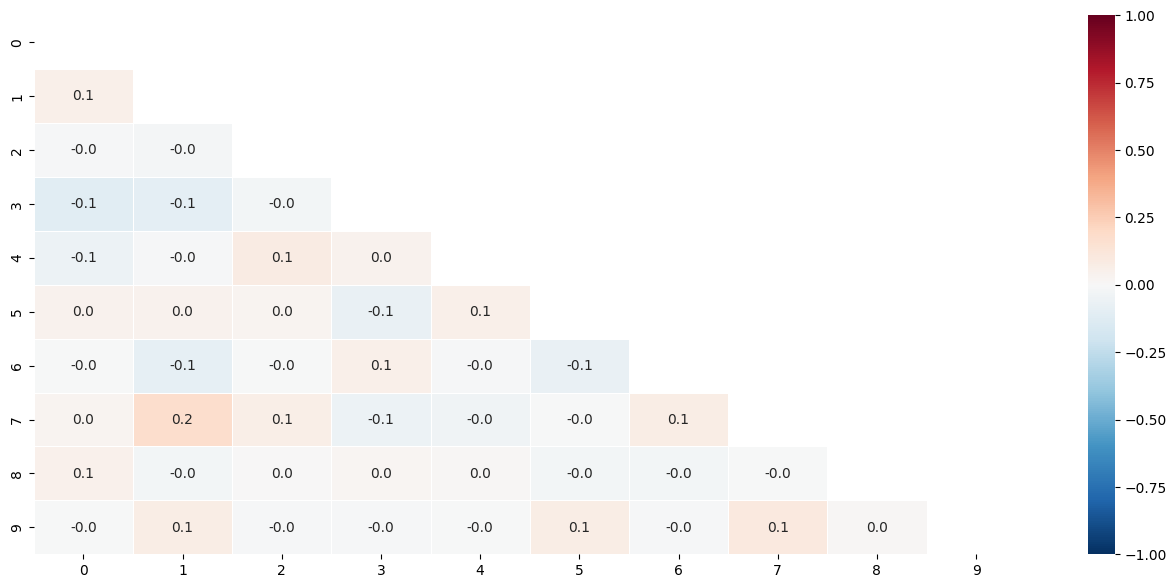

In [19]:
# Using Sparman's (non-linear relationship) - doesn't assume normal distribution
corr, _ = spearmanr(X_pca)

# Getting just the triangle of the correlation matrix
triangle = np.triu(corr)

# Plotting a heatmap with Seaborn
plt.figure(figsize=(16, 7))
sns.heatmap(data=corr, annot=True, mask=triangle, vmin=-1, vmax=1, cmap='RdBu_r', linewidths=.5, fmt= '.1f') # with 1 decimal precision